In [1]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
from training import optimization as opt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

plt.style.use("bmh")

### Define MLP model structure

In [2]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, n_layers, n_units, bias):
        super().__init__()
        self.input_size = input_size
        self.n_units  = n_units
        self.n_layers = n_layers
        self.bias = bias
        
        self.input_layer = torch.nn.Linear(self.input_size, self.n_units, bias=self.bias)
        self.relu = torch.nn.ReLU()
        self.hidden_layer = torch.nn.Linear(self.n_units, self.n_units, bias=self.bias)
        self.output_layer = torch.nn.Linear(self.n_units, 1, bias=self.bias)
    def forward(self, x):
        x = self.input_layer(x)
        
        for l in range(self.n_layers):
            x = self.hidden_layer(x)
            x = self.relu(x)
                    
        output = self.output_layer(x)
        
        return output

class MLPWrapper():
    def __init__(self, 
                 learning_rate=None,
                 n_units=None,
                 n_layers=None,
                 optimizer=None,
                 input_size=None,
                 trial=None):

        self.model_name = "mlp"
        self.search_type = 'random'

        learning_rate = learning_rate if learning_rate is not None else trial.suggest_float("learning_rate", 1e-5, 1e-1)
        n_units = n_units if n_units is not None else trial.suggest_int("n_units", 10, 1000)
        n_layers = n_layers if n_layers is not None else trial.suggest_int("n_layers", 2, 1000)
        optimizer = optimizer if optimizer is not None else trial.suggest_categorical("optimizer", ["SGD"])
        input_size = trial.suggest_int("input_size", input_size, input_size)

        self.params = {
              'learning_rate': learning_rate,
              'n_units': n_units,
              'n_layers': n_layers,
              'optimizer': optimizer,
              'input_size': input_size,
              }
        self.epochs = 500

        self.ModelClass = MLP

### Set global parameters

In [3]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
target_name = "betas_dgp"
dir_name = "var_0.05_1_150"
d_name = "betadgp_covdgp_data"
train_size = 0.7
wrapper = MLPWrapper
criterion = torch.nn.MSELoss()
verbose = False
n_iter = 1
n_jobs = 3
seed = 2294

### Load train/test data

In [4]:
train_data = pd.read_csv(os.path.join(inputs_path, dir_name, d_name + "_train.csv"))
train_data.set_index(["eq", "variable"], inplace=True)
y_train = train_data[[target_name]].to_numpy()
X_train = train_data.drop([target_name], axis=1).to_numpy()

test_data = pd.read_csv(os.path.join(inputs_path, dir_name, d_name + "_test.csv"))
test_data.set_index(["eq", "variable"], inplace=True)
y_test = test_data[[target_name]].to_numpy()
X_test = test_data.drop([target_name], axis=1).to_numpy()

### Sanity check inputs

No handles with labels found to put in legend.


Text(0.5, 0, "proxy phi's (covariance)")

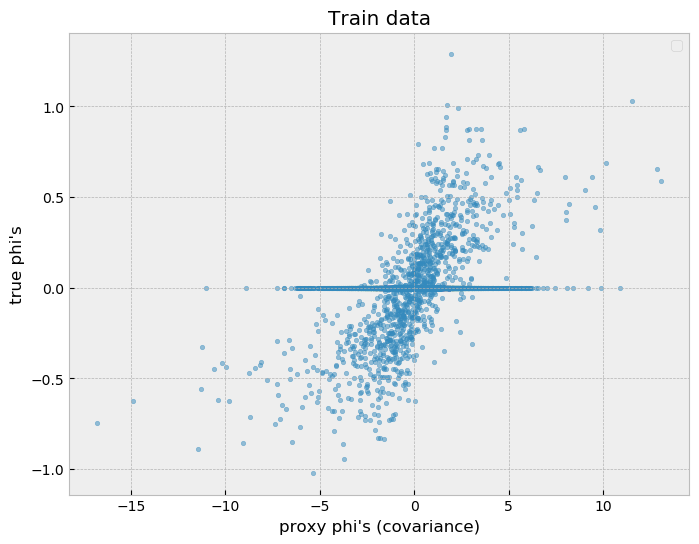

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(y=y_train,
            x=X_train,
            s=10,
            alpha=0.5)
plt.legend(loc='upper right')
plt.title("Train data")
plt.ylabel("true phi's")
plt.xlabel("proxy phi's (covariance)")

No handles with labels found to put in legend.


Text(0.5, 0, "proxy phi's (covariance)")

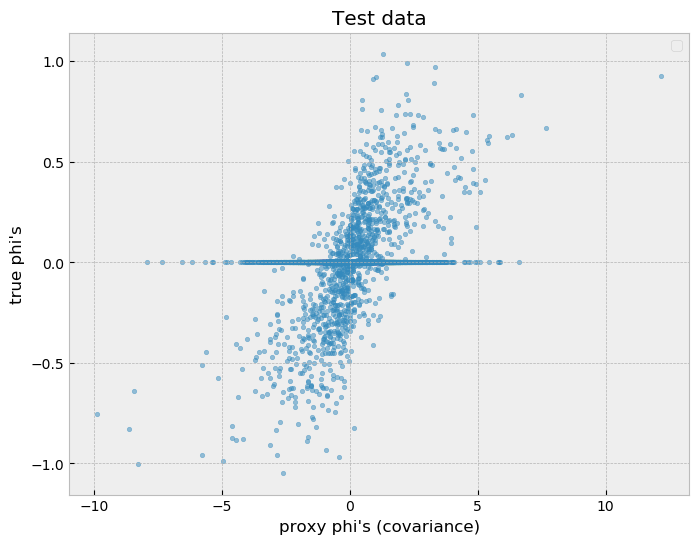

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(y=y_test,
            x=X_test,
            s=10,
            alpha=0.5)
plt.legend(loc='upper right')
plt.title("Test data")
plt.ylabel("true phi's")
plt.xlabel("proxy phi's (covariance)")

### Separate train data into train and validation + standardize inputs

In [7]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=train_size)

scaler = StandardScaler()
X_train_zscore = scaler.fit_transform(X_train)
X_validation_zscore = scaler.transform(X_validation)
X_test_zscore = scaler.transform(X_test)

### Train MLP - MSE

In [8]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(lambda trial: opt.objective(

    y_train=y_train,
    X_train=X_train_zscore,
    y_validation=y_validation,
    X_validation=X_validation_zscore,
    X_test=X_test_zscore,
    model_wrapper=wrapper,
    criterion=criterion,
    verbose=verbose,
    trial=trial

    ), n_trials=n_iter, n_jobs=n_jobs)

[I 2023-02-24 19:15:47,686] A new study created in memory with name: no-name-06dbecf2-c37e-431c-92ec-87f9fa7bfe7c


### Train MLP - WMSE

In [31]:
from training import loss_functions as lossf

studyw = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=seed))
studyw.optimize(lambda trial: opt.objective(

    y_train=y_train,
    X_train=X_train_zscore,
    y_validation=y_validation,
    X_validation=X_validation_zscore,
    X_test=X_test_zscore,
    model_wrapper=wrapper,
    criterion=lossf.WMSELoss,
    verbose=verbose,
    trial=trial

    ), n_trials=n_iter, n_jobs=n_jobs)

[I 2023-02-23 18:49:52,406] A new study created in memory with name: no-name-9ee9e3cd-cf2f-4e33-bc1e-f7c54537975e
[I 2023-02-23 18:59:32,035] Trial 0 finished with value: 0.005367252044379711 and parameters: {'learning_rate': 0.06536175897039745, 'n_units': 1000, 'n_layers': 2, 'optimizer': 'SGD', 'input_size': 1}. Best is trial 0 with value: 0.005367252044379711.


In [ ]:
{'learning_rate': 0.06536175897039745, 'n_units': 1000, 'n_layers': 2, 'optimizer': 'SGD', 'input_size': 1}. Best is trial 0 with value: 0.005367252044379711

### Train linear regression - MSE

In [34]:
linear_reg = LinearRegression()
linear_reg_fit = linear_reg.fit(X=X_train_zscore,
                                y=y_train)

test_pred = linear_reg_fit.predict(X_test_zscore)
output = pd.DataFrame({"eq": test_data.reset_index()["eq"],
                       "variable": test_data.reset_index()["variable"],
                       "y": y_test.ravel(),
                       "pred": test_pred.ravel()})

### Evaluate training results

In [9]:
print("MLP with MSE loss: ", study.best_trial.params)
print("MLP with WMSE loss: ", studyw.best_trial.params)

MLP with MSE loss:  {'learning_rate': 0.09088562688832927, 'n_units': 88, 'n_layers': 2, 'optimizer': 'SGD', 'input_size': 1}


NameError: name 'studyw' is not defined

In [12]:
test_pred = pd.DataFrame({"eq": test_data.reset_index()["eq"],
                         "variable": test_data.reset_index()["variable"],
                         "y": y_test.ravel(),
                         "pred": study.best_trial.user_attrs["test_predictions"].squeeze(),
                         "predw": studyw.best_trial.user_attrs["test_predictions"].squeeze(),
                         "pred_lr": output.pred})

print("Test MSE for MLP with MSE loss: ", mean_squared_error(y_true=test_pred["y"], y_pred=test_pred["pred"]))
print("Test MSE for MLP with WMSE loss: ", mean_squared_error(y_true=test_pred["y"], y_pred=test_pred["predw"]))
print("Test MSE for linear reg. with MSE loss: ", mean_squared_error(y_true=test_pred["y"], y_pred=test_pred["pred_lr"]))

Test MSE for MLP with MSE loss:  0.00556771831063627
Test MSE for MLP with WMSE loss:  0.005596636203512761
Test MSE for linear reg. with MSE loss:  0.005642765963058436


Text(0.5, 1.0, 'Test data predictions')

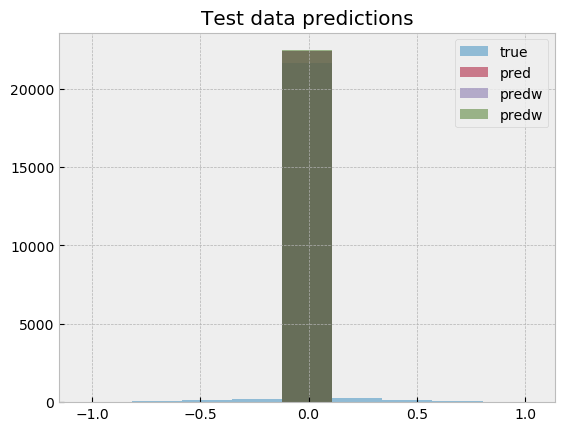

In [13]:
bins = np.linspace(test_pred.drop(["eq", "variable"], axis=1).min().min(),
                   test_pred.drop(["eq", "variable"], axis=1).max().max(),
                   10)
plt.hist(test_pred["y"], bins, alpha=0.5, label="true")
plt.hist(test_pred["pred"], bins, alpha=0.5, label="pred")
plt.hist(test_pred["predw"], bins, alpha=0.5, label="predw")
plt.hist(test_pred["pred_lr"], bins, alpha=0.5, label="predw")
plt.legend(loc='upper right')
plt.title("Test data predictions")
# plt.ylabel("true phi's")
# plt.xlabel("proxy phi's (covariance)")